# Мария Шерина, 2 группа
## Работа с госзатратами
Я решила собрать данные из госкаталога. Для этого я решила взять 2 параметра: минимальная сумма контракта в рублях (100.000.000) и максимальная сумма контракта в рублях (20.000.000.000), потому что иначе датасет был слишком маленьким. При этом для усложнения кода я также решила поставить ограничения в виде дат - границы составления контрактов. Для удобства я использовала библиотеку datetime, так как без дополнительных настроек не получалось парсить достаточное количество строк.
Чтобы реализовать возможность сбора больше, чем 500 строк, я решила воспользоваться библиотекой time, чтобы иметь возможность, когда возникнет ошибка вследствие превышения количества парсинга возможных строк, поставить код "на паузу".

In [53]:
# экспорт библиотек
import pandas as pd
import requests
import time # для пауз
from datetime import datetime, timedelta # для дат
from flatten_json import flatten

In [54]:
# ключ API и url
key = "2lFZdq2qc5aj6i20Qg9Crl1UifybvY2X"
base_url = "https://newapi.clearspending.ru/csinternalapi/v1/filtered-contracts/"
list_of_all_dfs = []

In [55]:
# создаем функцию для 5 попыток, чтобы посылать запросы еще в случае ошибки 429, 
# которая возникает, когда количество запросов превышает 500 строк. 
# если возникнет ошибка, код поставится на "паузу" еще раз, время увеличится
def makeRequest(url): 
    for attempt in range(5): 
        try:
            response = requests.get(url, timeout=20)
            if response.status_code == 429:
                wait = int(response.headers.get('Retry-After', 30))
                print(f"Слишком много запросов. Ждем {wait} сек...")
                time.sleep(wait)
                continue
            response.raise_for_status()
            return response.json()
        except Exception as e:
            print(f"Ошибка: {str(e)}")
            time.sleep(2 ** attempt)
    return None

In [56]:
# для дат создаем генератор временных интервалов, будем собирать данные за каждые три месяца
def date_ranges(start_date, end_date, delta_months=3):
    current = datetime.strptime(start_date, "%Y-%m-%d")
    end = datetime.strptime(end_date, "%Y-%m-%d")
    
    while current < end:
        next_date = current + timedelta(days=30*delta_months)
        yield (
            current.strftime("%Y-%m-%d"),
            min(next_date, end).strftime("%Y-%m-%d")
        )
        current = next_date


In [57]:
# собираем данные по временным периодам с 01.01.2005 до 12.31.2023, каждые 3 месяца
for date_gte, date_lte in date_ranges("2005-01-01", "2023-12-31"):
    print(f"\nОбрабатываем период: {date_gte} - {date_lte}")
    
    # для каждого временного периода запускаем процесс парсинга по нашим параметрам. начинаем с 1 страницы
    page = 1
    while True:
        url = "https://newapi.clearspending.ru/csinternalapi/v1/filtered-contracts/?apikey=" + key + "&amount_rur_gte=100000000&amount_rur_lte=20000000000&page=%s"
        url += f"&sign_date_gte={date_gte}&sign_date_lte={date_lte}&page={page}"
        
        data = makeRequest(url)

        # проверяем, если данных больше нет, то останавлвиаемся
        if not data:
            break
            
        # проверяем, если данных больше на странице нет, то останавлвиаемся
        if not data.get('data'):
            break
        
        # пробуем данные добавить в наш датасет
        try:
            df = pd.DataFrame()
            for record in data['data']:
                ser = pd.Series(flatten(record))
                #df = df.append(ser.to_frame().T)
                df = pd.concat([df, ser.to_frame().T], ignore_index=True)
            list_of_all_dfs.append(df)
            print(f"Страница {page}\nЗаписей: {len(df)}")
        except Exception as e:
            print(f"Ошибка обработки: {str(e)}")
        
        # проверяем, последняя ли это страница - если да, выходим
        if page >= data.get('totalPages', 1):
            break
            
        # переходим на следующую страницу    
        page += 1
        
        # добавляем задержку между страницами
        time.sleep(1.2)
        
print("Done")
print(f"Итого записей: {len(final_df)}")



Обрабатываем период: 2005-01-01 - 2005-04-01
Страница 1
Записей: 7

Обрабатываем период: 2005-04-01 - 2005-06-30
Страница 1
Записей: 11

Обрабатываем период: 2005-06-30 - 2005-09-28
Страница 1
Записей: 3

Обрабатываем период: 2005-09-28 - 2005-12-27
Страница 1
Записей: 20

Обрабатываем период: 2005-12-27 - 2006-03-27
Страница 1
Записей: 20

Обрабатываем период: 2006-03-27 - 2006-06-25
Страница 1
Записей: 19

Обрабатываем период: 2006-06-25 - 2006-09-23
Страница 1
Записей: 20

Обрабатываем период: 2006-09-23 - 2006-12-22
Страница 1
Записей: 20

Обрабатываем период: 2006-12-22 - 2007-03-22
Страница 1
Записей: 20

Обрабатываем период: 2007-03-22 - 2007-06-20
Страница 1
Записей: 20

Обрабатываем период: 2007-06-20 - 2007-09-18
Страница 1
Записей: 20

Обрабатываем период: 2007-09-18 - 2007-12-17
Страница 1
Записей: 20

Обрабатываем период: 2007-12-17 - 2008-03-16
Страница 1
Записей: 20

Обрабатываем период: 2008-03-16 - 2008-06-14
Страница 1
Записей: 20

Обрабатываем период: 2008-06-14 - 2

In [58]:
list_of_all_dfs

[         amount    amount_rur currency current_stage customer_inn  \
 0  452190527.95  452190527.95      RUB          None   2722027157   
 1  572023774.37  572023774.37      RUB          None   2722027157   
 2   334234996.0   334234996.0      RUB          None   2722027157   
 3  1943420970.0  1943420970.0      RUB          None   7710525541   
 4   155058000.0   155058000.0      RUB          None   5024129524   
 5  105244537.83  105244537.83      RUB          None   7728116437   
 6  694629312.44  694629312.44      RUB          None   7728094832   
 
   customer_kpp                                      customer_name  \
 0    272201001  федеральное казенное учреждение "Отдел капитал...   
 1    272201001  федеральное казенное учреждение "Отдел капитал...   
 2    272201001  федеральное казенное учреждение "Отдел капитал...   
 3    771001001  Федеральное государственное унитарное предприя...   
 4    502401001  Министерство строительного комплекса Московско...   
 5    772801001  Ф

In [64]:
# превращаем в конечный датасет
df_all = pd.DataFrame()
for df in list_of_all_dfs:
    df_all = pd.concat([df_all,df])

# превращаем в csv файл
df_all.to_csv("goscontracts.csv", index=False)

In [65]:
df_all

,amount,amount_rur,currency,current_stage,customer_inn,customer_kpp,customer_name,exec_start_date,exec_start_date_timestamp,fed_district_code,...,product_names_1008,product_names_1009,product_names_1010,product_names_1011,product_names_1012,product_names_1013,product_names_1014,product_names_1015,product_names_1016,product_names_1017
0,452190527.95,452190527.95,RUB,None,2722027157,272201001,"федеральное казенное учреждение ""Отдел капитал...",None,None,DFO,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,572023774.37,572023774.37,RUB,None,2722027157,272201001,"федеральное казенное учреждение ""Отдел капитал...",None,None,DFO,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,334234996.0,334234996.0,RUB,None,2722027157,272201001,"федеральное казенное учреждение ""Отдел капитал...",None,None,DFO,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1943420970.0,1943420970.0,RUB,None,7710525541,771001001,Федеральное государственное унитарное предприя...,None,None,CFO,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,155058000.0,155058000.0,RUB,None,5024129524,502401001,Министерство строительного комплекса Московско...,None,None,CFO,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15,168262500.0,168262500.0,RUB,None,8608045240,860801001,"ОБЩЕСТВО С ОГРАНИЧЕННОЙ ОТВЕТСТВЕННОСТЬЮ ""МЕЖД...",2024-03-01,None,URFO,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
16,124864846.21,124864846.21,RUB,None,4345083100,781001001,"АКЦИОНЕРНОЕ ОБЩЕСТВО ""ГАЗПРОМ ДИАГНОСТИКА""",2023-12-30,None,SZFO,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
17,138206614.99,138206614.99,RUB,None,4345083100,781001001,"АКЦИОНЕРНОЕ ОБЩЕСТВО ""ГАЗПРОМ ДИАГНОСТИКА""",2023-12-30,None,SZFO,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
18,130568239.51,130568239.51,RUB,None,4345083100,781001001,"АКЦИОНЕРНОЕ ОБЩЕСТВО ""ГАЗПРОМ ДИАГНОСТИКА""",2023-12-30,None,SZFO,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Далее проведем разведочный анализ.

In [76]:
# основная информация о данных
print(df_all.info())

<class 'pandas.core.frame.DataFrame'>
Index: 1520 entries, 0 to 19
Columns: 2066 entries, amount to product_names_1017
dtypes: object(2066)
memory usage: 24.0+ MB
None


In [112]:
import matplotlib.pyplot as plt
import seaborn as sns

Группировка и визуализация.

region_code
02    281215290566.790039
77    211487212921.869934
78     138234056975.97998
27     39481490825.730011
50     35775072194.179993
             ...         
53           228828432.57
64            218364509.0
48            100082500.0
91              2775570.0
15              2202000.0
Name: amount, Length: 79, dtype: object


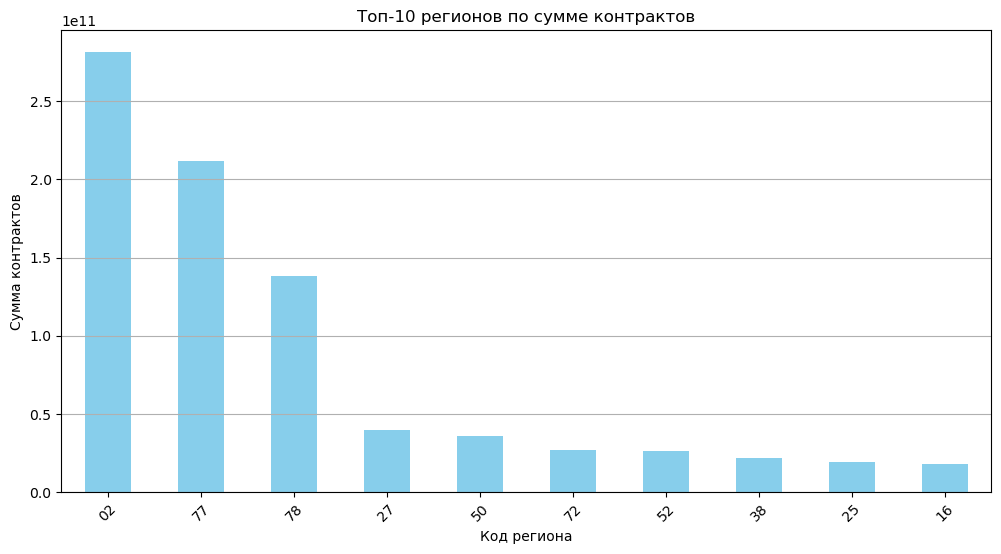

In [126]:
# сгруппируем по коду региона и сумме денег
region_sum = df_all.groupby('region_code')['amount'].sum().sort_values(ascending = False)
print(region_sum)

# топ-10 регионов
plt.figure(figsize=(12, 6))
region_sum.head(10).plot(kind='bar', color='skyblue')
plt.title('Топ-10 регионов по сумме контрактов')
plt.xlabel('Код региона')
plt.ylabel('Сумма контрактов')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()

Хочется отметить, что в топе-10 регионов по сумме контрактов находятся 82 (Крым), 77 (Москва) и 78 (Санкт-Петербург) - скорее всего, именно в этих регионах реализуются крупные проекты и программы развития, причем эти три региона имеют большой отрыв от остальных.

   region_code  regnum
0           01      11
1           02     346
2           03      12
3           04       2
4           05      16
..         ...     ...
74          83       2
75          86      23
76          87       1
77          89      11
78          91       1

[79 rows x 2 columns]


<Figure size 1200x600 with 0 Axes>

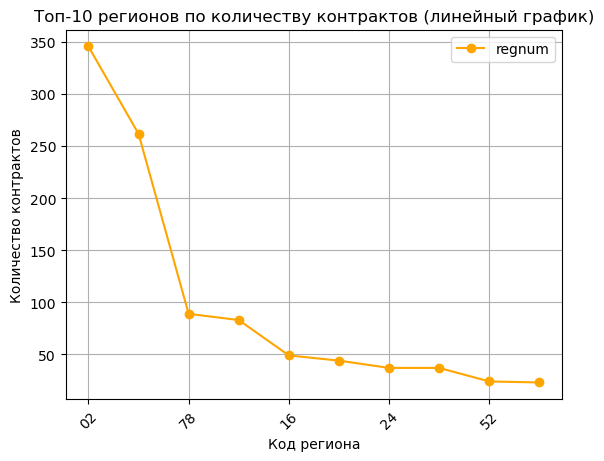

In [129]:
# сгруппируем по регионам и количестве контрактов
region_count = df_all.groupby('region_code')['regnum'].count().reset_index()
print(region_count)

# количество контрактов по регионам
plt.figure(figsize=(12, 6))
region_count.sort_values(by='regnum', ascending=False).head(10).plot(kind='line', x='region_code', y='regnum', marker='o', color='orange')
plt.title('Топ-10 регионов по количеству контрактов (линейный график)')
plt.xlabel('Код региона')
plt.ylabel('Количество контрактов')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

В топе-10 регионов по количеству контрактов регион с кодом 02 (Башкортостан) имеет 346 контрактов - это самое большое значение, однако он не находится в предыдущем топе - возможно, что в этом регионе преобладают низкие по стоимости заказы, но в большом количеству. 

region_code
01    307130799.607273
02    812760955.395347
03    218406362.309167
04         204671750.0
05     267423038.89125
            ...       
83        325297472.64
86    417582457.053913
87        1769965750.0
89    441768683.089091
91           2775570.0
Name: amount, Length: 79, dtype: object


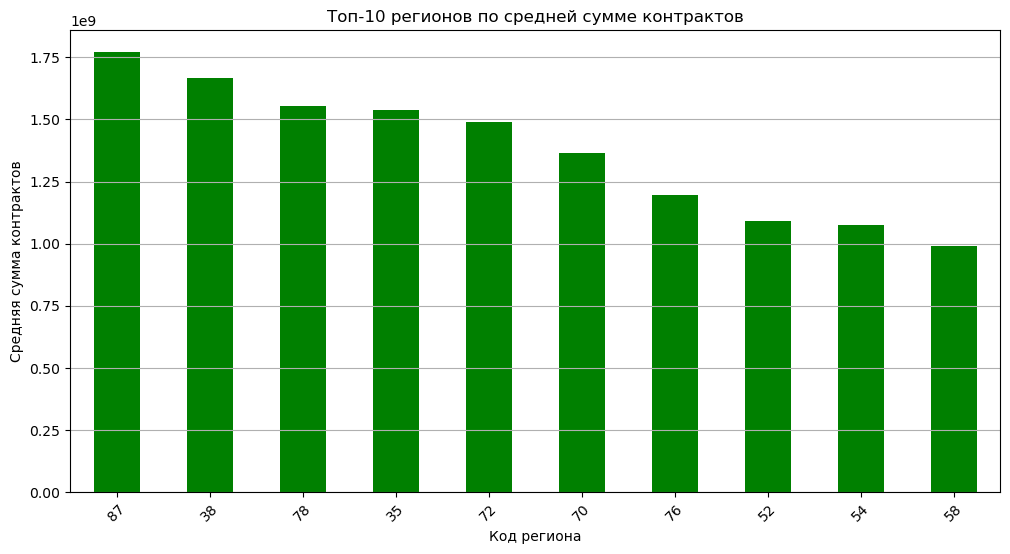

In [130]:
# сгруппируем по регионам и средней сумме контрактов
region_avg = df_all.groupby('region_code')['amount'].mean()
print(region_avg)

#топ-10 регионов по средней сумме контрактов
plt.figure(figsize=(12, 6))
region_avg.sort_values(ascending=False).head(10).plot(kind='bar', color='green')
plt.title('Топ-10 регионов по средней сумме контрактов')
plt.xlabel('Код региона')
plt.ylabel('Средняя сумма контрактов')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()

Топ-10 регионов по средней сумме контрактов показывает, что регион с кодом 87 (Ямало-Ненецкий автономный округ) имеет среднюю сумму контрактов 1.769.965.758 рублей, что является самым высоким значением. Это может быть связано с различными крупными проектами - например, с развитием определенных отраслей. График показывает, что средняя сумма контрактов варьируется значительно - значит, что имеются различия в структуре государственных заказов между регионами.

  region_code        amount
0          24   113467000.0
1          40   250000000.0
2          50   299200000.0
3          63   110702130.0
4          77  402241593.61
5          78  138206614.99
6          86   168262500.0


<Figure size 1200x600 with 0 Axes>

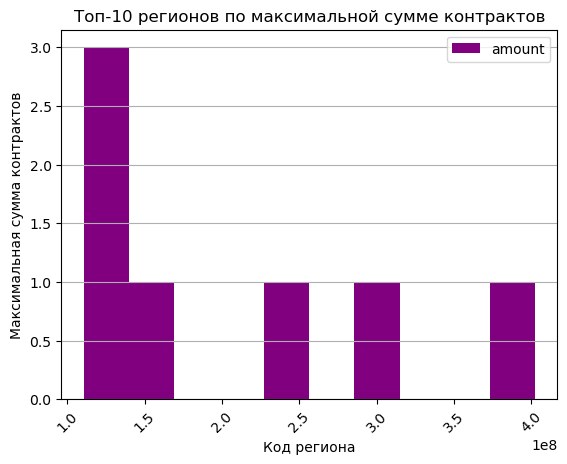

In [131]:
# сгруппируем по регионам и максимальная сумма контрактов
region_max = df.groupby('region_code')['amount'].max().reset_index()
print(region_max)

#топ-10 регионов по максимальной сумме контрактов
plt.figure(figsize=(12, 6))
region_max.sort_values(by='amount', ascending=False).head(10).plot(kind='hist', x='region_code', y='amount', color='purple')
plt.title('Топ-10 регионов по максимальной сумме контрактов')
plt.xlabel('Код региона')
plt.ylabel('Максимальная сумма контрактов')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()

В последнем графике, где регионы отсортированы по максимальной сумме контрактов, регион с кодом 77 (Москва) имеет максимальную сумму контрактов 402.241.593 рубля - очевидно, это связано с тем, что Москва - столица России, экономическим и политическим центром, и в ней все еще продолжается строительство метро, дорог, и т.д.


Средняя и медиана по цене.

In [136]:
df_all['amount'].mean() # среднее по цене

698268448.0559733

In [137]:
df_all['amount'].median() # медиана по цене

215079523.615

### Результаты и выводы
У меня получилось собрать 1520 записей из Госзакупок, бюджет которых был от 100.000.000 до 20.000.000.000 рублей, в период с 2005 до 2023 года включительно. Благодаря срезам данных и визуализации я заметила, что:

1. Государственные контракты распределены неравномерно между регионами. Крупные экономические центры, такие как Москва и Санкт-Петербург получают значительные объемы финансирования, отчего могут страдать более мелкие регионы.

2. В некоторых регионах преобладают мелкие заказы (большое количество контрактов с небольшой суммой), в то время как в других — крупные проекты (меньше контрактов, но с большими суммами).

3. Некоторые регионы, такие как Ямало-Ненецкий автономный округ, выделяются высокой средней и максимальной суммой контрактов, что может быть связано с крупными инфраструктурными или промышленными проектами.
